In [19]:
import os
from fastai.vision.all import *
import torch
from fastai.layers import Lambda
from fastai.tabular.all import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import socket
from sklearn.preprocessing import RobustScaler
from torch.utils.data import WeightedRandomSampler



In [20]:
# globlas
#print computer name:
comp_name = str(socket.gethostname())
base_path = str('')
if (comp_name == 'shairlab.upper.2080'):
    base_dir = Path('/home/jesse/lab/trans_stamp/')


In [21]:
print(os.getcwd())

/home/jesse/lab/trans_stamp/scgpt/jesse_utils


In [22]:
#function for running analysis
def regression_baseline(genexp, y_col, non_score_cols):
    '''

    :param genexp: a df of genexp
    :param y_col: the name of the label col
    :param non_score_cols: name of cols to drop for X as a list
    :return: nome
    '''


    # Preprocess the data (Assuming 'label' is your target variable)
    X = genexp .drop(non_score_cols, axis=1)
    y = genexp [y_col]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Train Random Forest
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Predictions and Evaluation for Random Forest
    rf_predictions = rf.predict(X_test)
    print('random forests:\n',classification_report(y_test, rf_predictions))


    # Train Elastic Net
    en = ElasticNet()
    en.fit(X_train, y_train)

    # Predictions and Evaluation for Elastic Net
    # Note: Elastic Net is a regression model; you might need to convert its predictions to a binary format for classification
    en_predictions = en.predict(X_test)
    en_predictions = [1 if p > 0.5 else 0 for p in en_predictions]  # Example threshold
    print('elsatic net:\n',classification_report(y_test, en_predictions))



In [23]:
def create_sample_weights(target_data):
    class_sample_counts = target_data.value_counts()
    weight = 1. / class_sample_counts
    samples_weight = weight[target_data].values
    return torch.DoubleTensor(samples_weight)

In [24]:
def create_dls(data,scale=True,scale_cols =2, regression = False, weighted = True):
    
    #apply scaling
    if scale:
        scaler = RobustScaler()
        data[data.columns[scale_cols:]] = scaler.fit_transform(data[data.columns[scale_cols:]])

    #get name of cols
    #find col with 'labal'
    label_col = [col for col in data.columns if 'label' in col]
    #print warning if more than one label col
    if len(label_col) > 1:
        print('more than one label col')
        print(label_col)
        print('using first label col')
        label_col = label_col[0]
    else:
        label_col = label_col[0]

    #get metadata cols: cols with label or sample_id
    metadata_cols = [col for col in data.columns if 'label' in col or 'Sample' in col]

    #print regression baseline:
    if regression:
        regression_baseline(data, label_col, metadata_cols)

    
    #create data loaders

    # Preprocess the data (Assuming 'label' is your target variable)
    #split scgpt_df into val and train
    train_df = data.sample(frac=0.8,random_state=200) #random state is a seed value
    val_df = data.drop(train_df.index)

    # create stacked tensor of sample vectors. each row is a sample, each col is a dim
    train_x = train_df.drop(metadata_cols, axis=1)
    train_x = torch.stack([tensor(row) for row in train_x.values], dim=0)
    train_y = tensor(train_df[label_col].values).float()
    
    val_x = val_df.drop(metadata_cols, axis=1)
    val_x = torch.stack([tensor(row) for row in val_x.values], dim =0)
    val_y = tensor(val_df[label_col].values).float()

    #create data sets from train and val x and y
    train_dset = list(zip(train_x,train_y))
    val_dset = list(zip(val_x,val_y))
    
    #create weighted sampler
    if weighted:
        train_sample_weights = create_sample_weights(train_df[label_col])
        train_sampler = WeightedRandomSampler(train_sample_weights, len(train_sample_weights))
        dl_train = DataLoader(train_dset, batch_size=64, sampler=train_sampler)
    #if not weighted, create dl without sampler
    if not weighted:
        dl_train = DataLoader(train_dset, batch_size=64)
    
    #create data loaders
    dl_val = DataLoader(val_dset, batch_size=64)

    #return dls
    return (dl_train, dl_val)

# create a simple neural net

now that we've fixed the gradiants and have proper learning

In [25]:
def stamp_loss(preds, targs):
    preds = preds.sigmoid()
    return torch.where(targs==1, 1-preds, preds).mean()

In [26]:

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [27]:
def first_nn(input_dim):
    nn_model = nn.Sequential(
    nn.Linear(input_dim, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
    Lambda(lambda x: x.squeeze(-1))
    )
    return nn_model

In [35]:
def run_nn(dl_train, dl_val, input_dim, epochs = 10, lr =0.1, find_lr = False, report = True):
    #having creted dataloadrs from data sets for train and cal, create a dls 
    dls = DataLoaders(dl_train, dl_val)

    model = first_nn(input_dim)
    
    #optimisers: Adam, AdamW, RMSProp, SGD
    #loss:nn.CrossEntropyLoss, nn.BCEWithLogitsLoss,
    # nn.CrossEntropyLoss(weight=class_weights)
    
    # Create your learner
    learn = Learner(dls, model, opt_func = Adam, loss_func=SGD, metrics=error_rate)

    #find suggested lr
    if find_lr:
        lr_suggestion = learn.lr_find()
        # Accessing the suggested learning rate
        lr = lr_suggestion.lr_min
    #train
    learn.fit(epochs, lr)

    # create classification report
    if report:
        '''# Get predictions
        preds, targets = learn.get_preds(dl=dls.valid)
        predictions = preds.argmax(dim=1)
    
        # Convert tensors to numpy arrays for compatibility with scikit-learn
        predictions_np = predictions.numpy()
        targets_np = targets.numpy()
    
        # Generate classification report
        print('Neural Network:\n', classification_report(targets_np, predictions_np))'''
        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix()
        plt.show()
        # Get top losses
        top_losses = interp.top_losses()
        

# load, examine and normalise data

In [29]:
# Load the data
data_path =Path(base_dir / 'scgpt/data/scgpt_embeddings/brca_sub_scgpt_emb.csv') 
scgpt_df = pd.read_csv(data_path)


In [30]:
# load raw genexp data
raw_genxp_path = Path(base_dir / 'scgpt/data/bulk_brca_erbb2/brca_ERBB2_genexp_oncosig_labels_gene_map.csv') 
raw_genexp = pd.read_csv(raw_genxp_path)

In [31]:
data = raw_genexp

#get dls
dl_train, dl_val = create_dls(data, weighted = True)

In [67]:
#trouble shoot dim problem with training

# Example check before the training loop
train_x, train_y = next(iter(dl_train))  # Fetch a batch from the training DataLoader

# Check shapes
print("Train_x shape:", train_x.shape)
print("Train_y shape:", train_y.shape)

# Assuming you have defined 'first_nn'
input_dim = 855  # Set this to the correct input dimension
model = first_nn(input_dim)

# Create a sample input tensor with the correct shape
# For example, if your input data is a vector per sample, you can create a dummy batch like this:
# Use a batch of data instead of a single sample
batch_input = torch.randn(64, input_dim)  # Mock batch with 64 samples

# Pass the sample input through the model
# Adjust the shape of the model's output
output = model(train_x)

# Print the output shape
print("Output shape:", output.shape)

# Check data types
print("Train_y data type:", train_y.dtype)


# If using BCEWithLogitsLoss
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(output, train_y.float())  # Convert labels to float
print("Loss:", loss)


Train_x shape: torch.Size([64, 855])
Train_y shape: torch.Size([64])
Output shape: torch.Size([64])
Train_y data type: torch.float32
Loss: tensor(0.7101, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [36]:
# Usage
run_nn(dl_train, dl_val, input_dim=855, epochs=10, lr=0.1, find_lr=False, report = False)

AssertionError: Trying to set 64 values for lr but there are 1 parameter groups.

# old dev cells

# Assuming 'dls' is your DataLoaders object and 'train' is the training DataLoader
batch = dls.train.one_batch()


In [7]:
#check data variation. each row is a sample, each col is a dim
curr_data =data
value_df = curr_data.drop(['Sample_ID','oncosig_label_ERBB2'], axis=1)
# Flatten the DataFrame to a single series and calculate mean and std
all_values = value_df.values.flatten()
overall_mean = all_values.mean()
overall_std = all_values.std()

print(f"Mean of entire DataFrame: {overall_mean}")
print(f"Standard Deviation of entire DataFrame: {overall_std}")



Mean of entire DataFrame: 8.752375429106664
Standard Deviation of entire DataFrame: 3.019593388750879


In [8]:
#get name of cols
#find col with 'labal'
label_col = [col for col in curr_data.columns if 'label' in col]
#print warning if more than one label col
if len(label_col) > 1:
    print('more than one label col')
    print(label_col)
    print('using first label col')
    label_col = label_col[0]
else:
    label_col = label_col[0]

In [9]:
#get metadata cols: cols with label or sample_id
metadata_cols = [col for col in curr_data.columns if 'label' in col or 'Sample' in col]

# examine data mean and std

# create Neural net

In [10]:
# Preprocess the data (Assuming 'label' is your target variable)
#split scgpt_df into val and train
train_df = curr_data.sample(frac=0.8,random_state=200) #random state is a seed value
val_df = curr_data.drop(train_df.index)



In [11]:
# create stacked tensor of sample vectors. each row is a sample, each col is a dim
train_x = train_df.drop(metadata_cols, axis=1)
print(train_x.iloc[0,500:512])
# Convert each row of the DataFrame to a tensor and stack them
train_x = torch.stack([tensor(row) for row in train_x.values], dim=0)
train_x.shape

STARD3     9.5088
SPP1      12.7887
DST       11.2423
DCDC2      5.4384
ERBB3     11.7830
ERBB4      9.1595
GJB2      10.8425
KIF18A     6.2226
KIF18B     6.4233
4-Mar      5.9467
STYK1      6.7230
CDKN2B     9.4294
Name: 776, dtype: float64


torch.Size([759, 855])

In [106]:
train_x[0,500:512],train_x.shape

(tensor([-0.2387,  0.4856, -0.2119, -0.1877, -0.9208, -0.0629,  0.7216, -0.5838, -0.5149,  1.9146,  0.1509,  0.5064]),
 torch.Size([759, 855]))

In [12]:
train_y = tensor(train_df[label_col].values)
train_y.shape,train_y[0:10]


(torch.Size([759]), tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0]))

In [13]:
val_x = val_df.drop(metadata_cols, axis=1)
val_x = torch.stack([tensor(row) for row in val_x.values], dim =0)

val_y = tensor(val_df[label_col].values)
val_y.shape,val_y[0],val_x.shape

(torch.Size([190]), tensor(0), torch.Size([190, 855]))

In [14]:
#create data sets from train and val x and y
train_dset = list(zip(train_x,train_y))
val_dset = list(zip(val_x,val_y))

In [16]:
#create data loaders
dl_train = DataLoader(train_dset, batch_size=64)
dl_val = DataLoader(val_dset, batch_size=64)

In [ ]:
#examine the the first few rows and cols
print(data.iloc[:5,:5])

# manual model

In [15]:
def stamp_loss(preds, targs):
    preds = preds.sigmoid()
    return torch.where(targs==1, 1-preds, preds).mean()

In [110]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()


In [123]:
# init weights
weights_1 = init_params(855,1)


bias_1 = init_params(1,1)

In [114]:

x,y= train_dset[0]
x.shape, y

(torch.Size([855]), tensor(0))

In [112]:
#simple linear layer

def linear1(xb): return xb@weights_1 + bias_1

In [115]:

xb,yb = first(dl_train)
xb.shape, yb.shape

(torch.Size([64, 855]), torch.Size([64]))

In [24]:
#test mini batch
batch = train_x[:100]
batch.shape

torch.Size([100, 512])

In [ ]:
preds = linear1(batch)
preds

In [26]:
loss = stamp_loss(preds, train_y[:100])
loss

tensor(0.5076, grad_fn=<MeanBackward0>)

In [ ]:
#for each sample in batch (tensor of 100 x 512) create a tensor of mean and sd, and then plot
batch_means = batch.mean(dim=1)
batch_stds = batch.std(dim=1)
#create hist of mean
plt.hist(batch_means.cpu().numpy(), bins=20)
plt.show()
plt.hist(batch_stds.cpu().numpy(), bins=20)
plt.show()

In [28]:
#get grad
loss.backward()
weights_1.grad.shape, weights_1.grad.mean(), bias_1.grad, weights_1.grad[:20]

(torch.Size([512]),
 tensor(1.4028e-05),
 tensor([0.1365]),
 tensor([-2.4886e-02,  1.4720e-02,  2.4593e-02,  2.0982e-02,  5.7275e-02,  3.2034e-02,  1.9298e-02,  4.5949e-02, -5.9231e-02,  9.0581e-05,  4.3937e-02, -4.5054e-03,  4.8138e-03,  8.5608e-03,
         -3.6844e-02, -6.6057e-02,  3.2865e-02,  2.8748e-02, -8.5472e-03,  9.2744e-03]))

In [116]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = stamp_loss(preds, yb)
    loss.backward()
    #print stat of grad: mean weights grad and 0:5 of weights grad
    print('mean grad:\n', weights_1.grad.mean(),'\n first 5 grad', weights_1.grad[:5])

In [117]:
def train_epoch(model, lr, params):
    for xb,yb in dl_train:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            #print first 5 weights
            #print('params:\n', p.data[:5])
            p.grad.zero_()

In [118]:

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [32]:
batch_accuracy(linear1(batch), train_y[:100])


tensor(0.4800)

In [119]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in dl_val]
    return round(torch.stack(accs).mean().item(), 4)

In [125]:
for i in range(20):
    #save initail weights and bias
    if i == 0:
        init_weights = weights_1.clone().detach()
        init_bias = bias_1.clone().detach()
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')
    #save ends weights and bias
    if i == 19:
        end_weights = weights_1.clone().detach()
        end_bias = bias_1.clone().detach()
        #calc percent change in weights and bias
        print('percent change in weights:\n', ((end_weights[:5] - init_weights[:5])),
              '\n first init weights:\n', init_weights[:5],
                '\n first end weights:\n', end_weights[:5])
    

mean grad:
 tensor(0.0001) 
 first 5 grad tensor([0.0070, 0.0000, 0.0074, 0.0009, 0.0056])
mean grad:
 tensor(-0.0003) 
 first 5 grad tensor([ 0.0059,  0.0000, -0.0007,  0.0022, -0.0048])
mean grad:
 tensor(-0.0031) 
 first 5 grad tensor([ 0.0095,  0.0000, -0.0082, -0.0065,  0.0017])
mean grad:
 tensor(0.0020) 
 first 5 grad tensor([0.0032, 0.0000, 0.0061, 0.0007, 0.0031])
mean grad:
 tensor(0.0003) 
 first 5 grad tensor([-0.0029,  0.0000,  0.0057, -0.0052, -0.0062])
mean grad:
 tensor(0.0003) 
 first 5 grad tensor([0.0011, 0.0000, 0.0020, 0.0014, 0.0067])
mean grad:
 tensor(-7.0838e-05) 
 first 5 grad tensor([-0.0023,  0.0000, -0.0003, -0.0011,  0.0013])
mean grad:
 tensor(-0.0009) 
 first 5 grad tensor([-0.0024,  0.0000, -0.0077, -0.0003, -0.0025])
mean grad:
 tensor(-0.0015) 
 first 5 grad tensor([ 0.0008,  0.0000, -0.0059, -0.0020, -0.0056])
mean grad:
 tensor(-0.0003) 
 first 5 grad tensor([ 0.0143,  0.0000, -0.0026,  0.0080,  0.0052])
mean grad:
 tensor(0.0010) 
 first 5 grad ten

In [124]:
#manual training
lr = 0.5
params = weights_1, bias_1


In [121]:
train_epoch(linear1, lr, params)
validate_epoch(linear1)

mean grad:
 tensor(-3.1388e-05) 
 first 5 grad tensor([ 0.0102,  0.0000,  0.0042, -0.0033,  0.0039])
mean grad:
 tensor(-0.0009) 
 first 5 grad tensor([-0.0047,  0.0000, -0.0034, -0.0021,  0.0017])
mean grad:
 tensor(-0.0006) 
 first 5 grad tensor([ 0.0017,  0.0000,  0.0041, -0.0127, -0.0035])
mean grad:
 tensor(-0.0002) 
 first 5 grad tensor([ 0.0049,  0.0000,  0.0049, -0.0081, -0.0131])
mean grad:
 tensor(0.0003) 
 first 5 grad tensor([-0.0019,  0.0000,  0.0001, -0.0065, -0.0056])
mean grad:
 tensor(-0.0009) 
 first 5 grad tensor([ 0.0009,  0.0000, -0.0061,  0.0024,  0.0066])
mean grad:
 tensor(0.0003) 
 first 5 grad tensor([ 0.0002,  0.0000,  0.0005, -0.0004,  0.0006])
mean grad:
 tensor(-0.0012) 
 first 5 grad tensor([-0.0030,  0.0000, -0.0097, -0.0068,  0.0012])
mean grad:
 tensor(-0.0012) 
 first 5 grad tensor([-0.0012,  0.0000, -0.0054,  0.0025,  0.0050])
mean grad:
 tensor(0.0002) 
 first 5 grad tensor([ 0.0168,  0.0000, -0.0071,  0.0074,  0.0073])
mean grad:
 tensor(-0.0006) 


0.4153

In [23]:
# Create a simple neural network

# input size is 512
nn_model = nn.Sequential(
    nn.Linear(855, 20),
    nn.ReLU(),
    nn.Linear(20, 1),
    nn.ReLU()
)

In [21]:
w,b = nn_model[0].parameters()
w.shape,b.shape


(torch.Size([256, 512]), torch.Size([256]))

In [18]:
#having creted dataloadrs from data sets for train and cal, create a dls 
dls = DataLoaders(dl_train, dl_val)

In [24]:

# Create your learner
learn = Learner(dls, nn_model, opt_func = SGD, loss_func=stamp_loss, metrics=error_rate)


SuggestedLRs(valley=1.5848931980144698e-06)

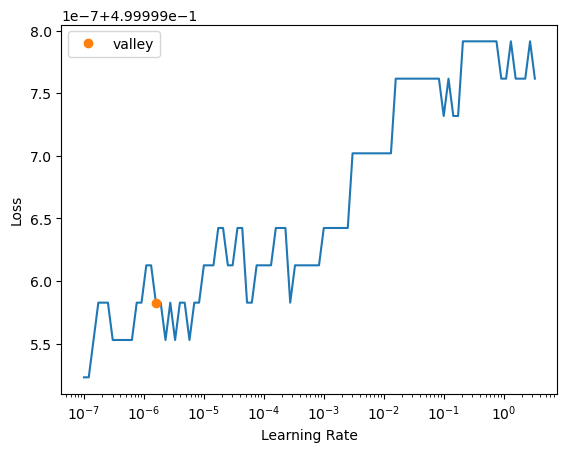

In [27]:
#find lr
learn.lr_find()


In [28]:
man_lr.

SuggestedLRs(valley=1.5848931980144698e-06)

In [25]:
learn.fit(10, 0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.528741,0.500000,0.105263,00:00
1,0.512637,0.500000,0.105263,00:00
2,0.507372,0.500000,0.105263,00:00
3,0.504816,0.500000,0.105263,00:00
4,0.503340,0.500000,0.105263,00:00
5,0.502402,0.500000,0.105263,00:00
6,0.501769,0.500000,0.105263,00:00
7,0.501324,0.500000,0.105263,00:00
8,0.501003,0.500000,0.105263,00:00
9,0.500766,0.500000,0.105263,00:00


In [131]:
# Assuming 'learn' is your Learner object and you have 'accuracy' as one of the metrics
last_epoch_metrics = learn.recorder.metrics[-1]



In [25]:

# Preprocess the data (Assuming 'label' is your target variable)
X = data .drop(['oncosig_label_ERBB2', 'Sample_ID'], axis=1)
y = data ['oncosig_label_ERBB2']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       166
           1       0.92      0.50      0.65        24

    accuracy                           0.93       190
   macro avg       0.93      0.75      0.81       190
weighted avg       0.93      0.93      0.92       190


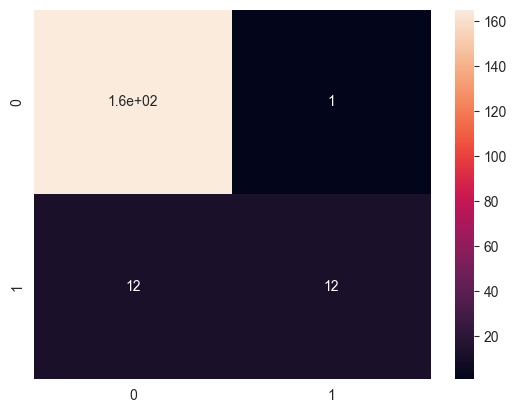

In [26]:

# Train Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predictions and Evaluation for Random Forest
rf_predictions = rf.predict(X_test)
print(classification_report(y_test, rf_predictions))
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True)
plt.show()


C:\Users\Jesse\Google Drive\Learning\shair lab\STAMP\laptop_venvs\gene_map_venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jesse\Google Drive\Learning\shair lab\STAMP\laptop_venvs\gene_map_venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jesse\Google Drive\Learning\shair lab\STAMP\laptop_venvs\gene_map_venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. U

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       166
           1       0.00      0.00      0.00        24

    accuracy                           0.87       190
   macro avg       0.44      0.50      0.47       190
weighted avg       0.76      0.87      0.81       190


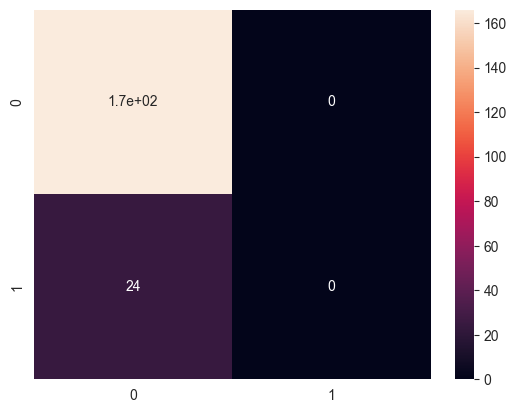

In [27]:

# Train Elastic Net
en = ElasticNet()
en.fit(X_train, y_train)

# Predictions and Evaluation for Elastic Net
# Note: Elastic Net is a regression model; you might need to convert its predictions to a binary format for classification
en_predictions = en.predict(X_test)
en_predictions = [1 if p > 0.5 else 0 for p in en_predictions]  # Example threshold
print(classification_report(y_test, en_predictions))
sns.heatmap(confusion_matrix(y_test, en_predictions), annot=True)
plt.show()
